In [ ]:
!pip install torchsummary
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
import cv2
import sklearn.neighbors as snn
import tqdm

import torch
import torchvision
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111
Using the GPU!


In [ ]:
!pip install -Uqq ipdb 
import ipdb

     |████████████████████████████████| 791 kB 5.1 MB/s 
     |████████████████████████████████| 374 kB 53.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.24 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.30.1 which is incompatible.


#DataSet

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 5.0 MB/s 
     |████████████████████████████████| 56 kB 6.4 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [ ]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"
    
paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))
print(val_paths)

8000 2000
['/root/.fastai/data/coco_sample/train_sample/000000213555.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000159606.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000037695.jpg' ...
 '/root/.fastai/data/coco_sample/train_sample/000000144203.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000231450.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000215002.jpg']


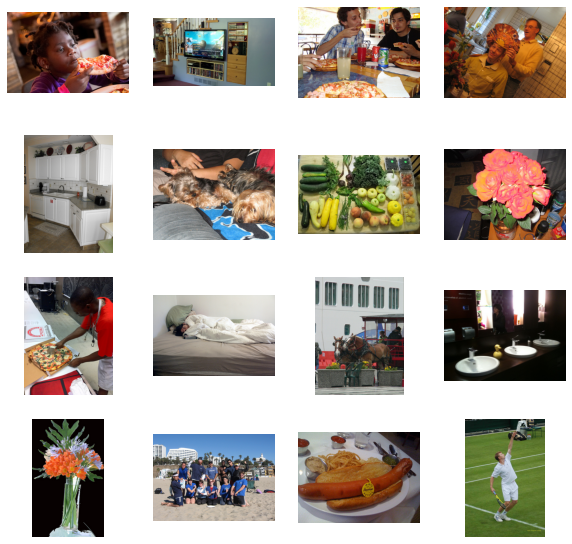

In [ ]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

#Get Data

In [ ]:
SIZE = 256
nb_neighbors = 5

class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        q_ab = np.load("pts_in_hull.npy")
        self.nn_finder = snn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)
        self.nb_q = q_ab.shape[0]

        self.split = split
        self.size = SIZE
        self.paths = paths

    def _get_soft_encoding(self, image_ab, nn_finder, nb_q):
        h, w = image_ab.shape[:2]
        a = np.ravel(image_ab[:, :, 0])
        b = np.ravel(image_ab[:, :, 1])
        ab = np.vstack((a, b)).T
        # Get the distance to and the idx of the nearest neighbors
        dist_neighb, idx_neigh = nn_finder.kneighbors(ab)
        # Smooth the weights with a gaussian kernel
        sigma_neighbor = 5
        wts = np.exp(-dist_neighb ** 2 / (2 * sigma_neighbor ** 2))
        wts = wts / np.sum(wts, axis=1)[:, np.newaxis]
        # format the tar get
        y = np.zeros((ab.shape[0], nb_q))
        idx_pts = np.arange(ab.shape[0])[:, np.newaxis]
        y[idx_pts, idx_neigh] = wts
        y = y.reshape(h, w, nb_q)
        return y
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)

        out_img_rows, out_img_cols = SIZE // 4, SIZE // 4
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.resize(gray, (SIZE, SIZE), cv2.INTER_CUBIC)
        x = gray / 255

        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        out_lab = cv2.resize(lab, (out_img_rows, out_img_cols), cv2.INTER_CUBIC)
        out_ab = out_lab[:, :, 1:].astype(np.int32) - 128
        y = self._get_soft_encoding(out_ab, self.nn_finder, self.nb_q)
        x_tensor = torch.tensor(x.copy(), dtype=torch.float32).unsqueeze(0)
        y_tensor = torch.tensor( y.transpose([2,0,1]).copy())
        return [x_tensor, y_tensor]


        # img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        # img_lab = transforms.ToTensor()(img_lab)
        # L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        # ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        # return L, ab
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

Ls, abs = next(iter(train_dl))
print(Ls.shape, abs.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type Interpolat

torch.Size([16, 1, 256, 256]) torch.Size([16, 313, 64, 64])
500 125


#Training Layers

In [ ]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.ab_norm = 110.
 
        self.model1=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64))
        
        self.model2=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128))
        
        self.model3=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256))
        
        self.model4=nn.Sequential(
            nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512))
        
        self.model5=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512))
        
        self.model6=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,dilation=2,stride=1,padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(512))
        
        self.model7=nn.Sequential(
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512))
        
        self.model8=nn.Sequential(
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,313,kernel_size=1,stride=1,padding=0),
            nn.BatchNorm2d(313)
        )
        
        self.softmax = nn.Softmax(dim=1)
        self.out = nn.Conv2d(313, 2, kernel_size=1, padding=0, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')
        
    def unnormalize_ab(self, in_ab):
        return in_ab*self.ab_norm
    
    
    def forward(self, x):
        input_1 = x
        conv1_2 = self.model1(input_1)
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.out(self.softmax(conv8_3))
        color_ab = self.upsample4(out_reg)

        return self.softmax(conv8_3), self.unnormalize_ab(color_ab)

def Colormodel():
    return Model

In [ ]:
print(Model())

Model(
  (model1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

#Train Steps

In [ ]:
def train_net(model, device, train_loader, optimizer, epoch, weight):

    model.train()
    print('start training')
    
    loss_record = [] # record loss in batches
    
    for batch_idx, data in enumerate(tqdm.tqdm(train_loader)):
        
#         data, _ = data # This is for imagenet training dataset
        x, gt = data
        x, gt = x.to(device), gt.to(device)
        optimizer.zero_grad()
        y,_ = model(x)
        # back propogate
        #loss = _loss(y, gt, weight)
        loss = _loss(y.float(),gt.float())
        if torch.isnan(loss):
            ipdb.set_trace()
        train_rec.take(loss / x.shape[0])
        loss.backward()
        optimizer.step()
        
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_rec.save()
    return

In [ ]:
# def _loss(y, gt, weight):  
#     # calculate loss
#     loss_tmp = - gt * torch.log(y + 1e-10)
#     loss_tmp_perpix = torch.sum(loss_tmp, axis = 1)
#     max_idx_perpix = torch.argmax(gt, axis = 1) 
#     prior_perpix = weight[max_idx_perpix.cpu()]
#     prior_perpix = torch.tensor(prior_perpix).to(device)

#     loss_perpix = prior_perpix * loss_tmp_perpix
#     loss = torch.sum(loss_perpix) / (y.shape[2] * y.shape[3])
    
#     return loss
_loss = nn.MSELoss()

In [ ]:
def test_net(model, device, test_loader, weight):
    model.eval()
    test_loss = 0
    print('start validation')
    with torch.no_grad():
        for x, gt in tqdm.tqdm(test_loader):
            x, gt = x.to(device), gt.to(device)
            y, _ = model(x)
            #test_loss += _loss(y, gt, weight).item()
            test_loss += _loss(y.float(),gt.float()).item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(
    test_loss))
            
    
    return test_loss

In [ ]:
class Loss_recorder():
    def __init__(self, loss_type):
        assert loss_type in ['train', 'val']
        self.type = loss_type
        self.loss_record = []
        
        if self.type == 'train':
            self.sub_loss_record = []
        
    def take(self,loss):
        if self.type == 'val':
            self.loss_record.append(loss)
        elif self.type == 'train':
            self.sub_loss_record.append(loss)
        
    def save(self,):
        
        if self.type == 'val':
            plt.plot(self.loss_record)
            plt.xlabel('epochs')
            plt.ylabel('val loss')
            plt.title('Model Convergence')
            plt.savefig('val_loss_epoches.png')
            print('val losse recorded.')
            plt.clf()

            
        else:
            self.loss_record.append(sum(self.sub_loss_record) /
                                   len(self.sub_loss_record))
            self.sub_loss_record = []
            
            plt.plot(self.loss_record)
#             plt.xlabel('per {} pochs'.format(args.log_interval))
            plt.xlabel('per {} batches'.format(200))
            plt.ylabel('train loss')
            plt.title('Model Convergence in Batches')
            plt.savefig('train_loss_batches.png')
            print('training losses recorded.')
            plt.clf()
            
    def reset(self,):
        self.loss_record = []
        
        if self.type == 'train':
            self.sub_loss_record = []


train_rec = Loss_recorder('train')
val_rec = Loss_recorder('val')

#Train Model

In [ ]:
num_epochs = 20
best_losses = 1e10
model = Model().to(device)
optimizer = optim.Adam(model.parameters(),
                          lr=3e-5,
                        betas = (0.9, 0.99),
                        weight_decay = 1e-3,
                        )
prior = np.load("prior_probs.npy")
weight = 1/(0.5 * prior + 0.5 / 313)
weight = weight / sum(prior * weight)
recorder = Loss_recorder('val') 

for epoch in range(num_epochs):
    train_net(model, device, train_dl, optimizer, epoch, weight)
    loss = test_net(model, device, val_dl, weight)
    print('epoch finished')
    if loss < best_losses:
      best_losses = loss
      torch.save(model.state_dict(), 'checkpoints/model-MSE-epoch-{}-loss-{:.3f}.pth'.format(epoch+1,loss))
    # record loss
    val_rec.take(loss)        
    val_rec.save()

start training


  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Train Epoch: 0 [0/8000 (0%)]	Loss: 0.001183


  0%|          | 1/500 [00:03<29:43,  3.57s/it]

training losses recorded.


 40%|████      | 200/500 [01:54<02:28,  2.02it/s]

Train Epoch: 0 [3200/8000 (40%)]	Loss: 0.001127


 40%|████      | 201/500 [01:56<04:28,  1.11it/s]

training losses recorded.


 80%|████████  | 400/500 [03:47<00:55,  1.79it/s]

Train Epoch: 0 [6400/8000 (80%)]	Loss: 0.001123


 80%|████████  | 401/500 [03:48<01:14,  1.34it/s]

training losses recorded.


100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


start validation


100%|██████████| 125/125 [01:05<00:00,  1.91it/s]



Test set: Average loss: 0.0001

epoch finished
val losse recorded.
start training


  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.001165


  0%|          | 1/500 [00:03<32:21,  3.89s/it]

training losses recorded.


 40%|████      | 200/500 [01:54<02:30,  2.00it/s]

Train Epoch: 1 [3200/8000 (40%)]	Loss: 0.001123


 40%|████      | 201/500 [01:56<04:03,  1.23it/s]

training losses recorded.


 80%|████████  | 400/500 [03:49<00:56,  1.76it/s]

Train Epoch: 1 [6400/8000 (80%)]	Loss: 0.001123


 80%|████████  | 401/500 [03:50<01:12,  1.36it/s]

training losses recorded.


100%|██████████| 500/500 [04:44<00:00,  1.76it/s]


start validation


100%|██████████| 125/125 [01:06<00:00,  1.89it/s]



Test set: Average loss: 0.0001

epoch finished
val losse recorded.
start training


  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.001165


  0%|          | 1/500 [00:03<30:57,  3.72s/it]

training losses recorded.


 40%|████      | 200/500 [01:51<02:29,  2.01it/s]

Train Epoch: 2 [3200/8000 (40%)]	Loss: 0.001123


 40%|████      | 201/500 [01:52<03:57,  1.26it/s]

training losses recorded.


 80%|████████  | 400/500 [03:40<01:02,  1.59it/s]

Train Epoch: 2 [6400/8000 (80%)]	Loss: 0.001123


 80%|████████  | 401/500 [03:41<01:22,  1.21it/s]

training losses recorded.


100%|██████████| 500/500 [04:34<00:00,  1.82it/s]


start validation


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]



Test set: Average loss: 0.0001

epoch finished
val losse recorded.
start training


  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.001165


  0%|          | 1/500 [00:03<29:18,  3.52s/it]

training losses recorded.


 40%|████      | 200/500 [01:51<02:49,  1.77it/s]

Train Epoch: 3 [3200/8000 (40%)]	Loss: 0.001123


 40%|████      | 201/500 [01:52<03:46,  1.32it/s]

training losses recorded.


 80%|████████  | 400/500 [03:41<00:58,  1.71it/s]

Train Epoch: 3 [6400/8000 (80%)]	Loss: 0.001123


 80%|████████  | 401/500 [03:43<01:19,  1.25it/s]

training losses recorded.


100%|██████████| 500/500 [04:36<00:00,  1.81it/s]


start validation


100%|██████████| 125/125 [01:05<00:00,  1.90it/s]



Test set: Average loss: 0.0001

epoch finished
val losse recorded.
start training


  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 4 [0/8000 (0%)]	Loss: 0.001165


  0%|          | 1/500 [00:03<28:07,  3.38s/it]

training losses recorded.


 22%|██▏       | 111/500 [01:03<03:42,  1.75it/s]
Exception in thread Thread-126:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.7/dist-packages/torch/multiprocessing/reductions.py", line 289, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=proces

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
my_model = Model()
my_model.load_state_dict(torch.load('/content/checkpoints/model-epoch-6-loss-3.510.pth'))
print(Model())

NameError: ignored

#Utils

In [ ]:
def load_img(img_path):
    out_np = np.asarray(Image.open(img_path))
    if(out_np.ndim==2):
        out_np = np.tile(out_np[:,:,None],3)
    return out_np

def resize_img(img, HW=(256,256), resample=3):
    return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
    # return original size L and resized L as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)

    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_orig = img_lab_orig[:,:,0]
    img_l_rs = img_lab_rs[:,:,0]

    tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
    tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

    return (tens_orig_l, tens_rs_l)

def postprocess_tens(tens_orig_l, out_ab, mode='bilinear'):
    # tens_orig_l 	1 x 1 x H_orig x W_orig
    # out_ab 		1 x 2 x H x W

    HW_orig = tens_orig_l.shape[2:]
    HW = out_ab.shape[2:]

    # call resize function if needed
    if(HW_orig[0]!=HW[0] or HW_orig[1]!=HW[1]):
        out_ab_orig = F.interpolate(out_ab, size=HW_orig, mode='bilinear')
    else:
        out_ab_orig = out_ab

    out_lab_orig = torch.cat((tens_orig_l, out_ab_orig), dim=1)
    return color.lab2rgb(out_lab_orig.data.cpu().numpy()[0,...].transpose((1,2,0)))


def display(my_model, filename):
    h, w = SIZE // 4, SIZE // 4

    # Load the array of quantized ab value
    q_ab = np.load("pts_in_hull.npy")
    nb_q = q_ab.shape[0]

    # Fit a NN to q_ab
    nn_finder = snn.NearestNeighbors(n_neighbors=nb_neighbors, algorithm='ball_tree').fit(q_ab)

    bgr_raw = cv2.imread(filename)
    gray_raw = cv2.imread(filename, 0)
    orig_shape = bgr_raw.shape[:2]
    orig_h = bgr_raw.shape[1]
    orig_w = bgr_raw.shape[0]

    bgr = cv2.resize(bgr_raw, (SIZE, SIZE), cv2.INTER_CUBIC)
    gray = cv2.resize(gray_raw, (SIZE, SIZE), cv2.INTER_CUBIC)
    # L: 0 <=L<= 255, a: 42 <=a<= 226, b: 20 <=b<= 223.
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    L = lab[:, :, 0]
    a = lab[:, :, 1]
    b = lab[:, :, 2]

    x_test = np.empty((1, 1,SIZE, SIZE), dtype=np.float32)
    x_test[0, 0, :, :] = gray / 255.

    # L: 0 <=L<= 255, a: 42 <=a<= 226, b: 20 <=b<= 223.
    X_colorized,_ = my_model(torch.tensor(x_test))
    X_colorized = X_colorized.cpu().detach().numpy().reshape((h * w, nb_q))

    # Reweight probas
    X_colorized = np.exp(np.log(X_colorized + 1e-8) / 0.38)
    X_colorized = X_colorized / np.sum(X_colorized, 1)[:, np.newaxis]

    # Reweighted
    q_a = q_ab[:, 0].reshape((1, 313))
    q_b = q_ab[:, 1].reshape((1, 313))

    X_a = np.sum(X_colorized * q_a, 1).reshape((h, w))
    X_b = np.sum(X_colorized * q_b, 1).reshape((h, w))

    X_a = cv2.resize(X_a, (SIZE, SIZE), cv2.INTER_CUBIC)
    X_b = cv2.resize(X_b, (SIZE, SIZE), cv2.INTER_CUBIC)
    X_a = X_a + 128
    X_b = X_b + 128
    out_lab = np.zeros((SIZE, SIZE, 3), dtype=np.int32)
    out_lab[:, :, 0] = lab[:, :, 0]
    out_lab[:, :, 1] = X_a
    out_lab[:, :, 2] = X_b
    out_L = out_lab[:, :, 0]
    out_a = out_lab[:, :, 1]
    out_b = out_lab[:, :, 2]
    out_lab = out_lab.astype(np.uint8)
    out_rgb = cv2.cvtColor(out_lab, cv2.COLOR_LAB2RGB)
    # print('np.max(out_bgr): ' + str(np.max(out_bgr)))
    # print('np.min(out_bgr): ' + str(np.min(out_bgr)))
    out_rgb = out_rgb.astype(np.uint8)

    out_rgb = cv2.resize(out_rgb,(orig_h, orig_w), cv2.INTER_CUBIC)
    rgb_raw = cv2.cvtColor(bgr_raw, cv2.COLOR_BGR2RGB)
    gray_raw = cv2.cvtColor(bgr_raw, cv2.COLOR_BGR2GRAY)

    return rgb_raw, gray_raw,  out_rgb 


#Test

In [ ]:
img_path = train_paths[2]
rgb_raw, gray_raw, out_rgb = display(my_model, img_path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(-0.5, 639.5, 477.5, -0.5)

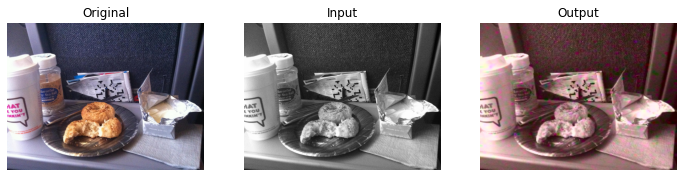

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(rgb_raw)
plt.title('Original')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(gray_raw, cmap='gray',)
plt.title('Input')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(out_rgb)
plt.title('Output')
plt.axis('off')

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [ ]:
s = ssim(rgb_raw, out_rgb, multichannel=True)
p = psnr(rgb_raw, out_rgb)
print(s)
print(p)

0.6947604538099315
19.662334599783375


In [ ]:
my_model = Model()
my_model.load_state_dict(torch.load('/content/checkpoints/model-MSE-epoch-3-loss-0.000.pth'))
psnrs = []
ssims = []
for i in range(1):
  img_path = train_paths[i]
  rgb_raw, gray_raw, out_rgb = display(my_model, img_path)
  psnrs.append(psnr(rgb_raw, out_rgb))
  ssims.append(ssim(rgb_raw, out_rgb, multichannel=True))


print(np.mean(psnrs))
print(np.mean(ssims))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


19.95970121595112
0.7305032676823386
